# Vietnamese Character Recognition Using Feature Selection

In this code, we explain the process of training a machine learning model to recognize Vietnamese handwritten characters. We also represent our method to select the feature, as well as in other steps of the machine learning process





## Table of content:
1. Data generating and preparing
2. Feature selection
3. Choosing model and model training
4. Model evaluation
5. Parameter tuning
6. Make prediction 

## 1. Data collecting and preparing:
**Note:  For re-executing this file, everyone can reuse our data on Google Drive. Then they need to be uploaded to running session in Colab. This code below assume that data have been uploaded sucessfully**

**Data collecting**  
Our dataset is based on the dataset of the ICFHR2018 Competition  
![](https://drive.google.com/uc?export=view&id=1NF9WZDkflRww697iUABYca0hoemJOjYn)
![](https://drive.google.com/uc?export=view&id=1c7mG5mvj3PC3Erjhzlgq_OxWqrfRaSoW)  

**Data preparing**  
We crop each character in the image and label them. Here is its format  
![](https://drive.google.com/uc?export=view&id=1tpxsE1mwQzCe3cKWfXh9R4V5QlRDoQi_) ![](https://drive.google.com/uc?export=view&id=1RFKCgly6IG9bXqSRgaBm-JcvfuSFt8eu) ![](https://drive.google.com/uc?export=view&id=18ucHllXMvBWPgl_OKS0NVdSqgdxA_NNp) ![](https://drive.google.com/uc?export=view&id=19gbjMaXWH5Y1wUhK_i-61msnB8X9nJuw) ![](https://drive.google.com/uc?export=view&id=15ZPjg6qo9XaAVsj9UVTZYNYByHeJDvPk)  
![](https://drive.google.com/uc?export=view&id=1e2qOOcxdctqeYF_GhSVdF1FQBur8XBlC) ![](https://drive.google.com/uc?export=view&id=12a-0q1pjrCKZcCo_HlMdZedCWON2Y_8B) ![](https://drive.google.com/uc?export=view&id=1PrJ5WkpQa1XlfQCQjUFmTKurzfszA3ky) ![](https://drive.google.com/uc?export=view&id=1IsUsdrMZMMFmQSnJU3PvsahYIOKqGGt6) ![](https://drive.google.com/uc?export=view&id=1_L3OY3SO6qFIjXMYcr4g9jVZNs0-mIiH)  
This dataset contains 3115 images

**Note:** We have uploaded our current dataset to Drive  
Link: https://drive.google.com/file/d/1LLPoGN26Oag6lp6x-TbSu8vv2OR-8gy4/view?usp=sharing

*Create a directory and unrar our data*

In [ ]:
#!rm -rf VN_CHAR
!mkdir VN_CHAR
!unrar x /content/dataset3000.rar /content/VN_CHAR


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/dataset3000.rar

Creating    /content/VN_CHAR/VN_CHAR                                  OK
Creating    /content/VN_CHAR/VN_CHAR/0                                OK
Extracting  /content/VN_CHAR/VN_CHAR/0/AHVOAUX.jpg                         0%  OK 
Extracting  /content/VN_CHAR/VN_CHAR/0/AUIJZYT.jpg                         0%  OK 
Extracting  /content/VN_CHAR/VN_CHAR/0/BFZGVBX.jpg                         0%  OK 
Extracting  /content/VN_CHAR/VN_CHAR/0/BXOFSPF.jpg                         0%  OK 
Extracting  /content/VN_CHAR/VN_CHAR/0/CYQZWLB.jpg                         0%  OK 
Extracting  /content/VN_CHAR/VN_CHAR/0/CZDOZOT.jpg                         0%  OK 
Extracting  /content/VN_CHAR/VN_CHAR/0/DQSUFDF.jpg                         0%  OK 
Extracting  /content/VN_CHAR/VN_CHAR/0/ECZGONI.jpg                         0%  OK 
Extract

*Install dependence library and import them*

In [ ]:
!pip install mahotas

from sklearn.tree import ExtraTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.svm.classes import OneClassSVM
from sklearn.neural_network.multilayer_perceptron import MLPClassifier
from sklearn.neighbors.classification import RadiusNeighborsClassifier
from sklearn.neighbors.classification import KNeighborsClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OutputCodeClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model.stochastic_gradient import SGDClassifier
from sklearn.linear_model.ridge import RidgeClassifierCV
from sklearn.linear_model.ridge import RidgeClassifier
from sklearn.linear_model.passive_aggressive import PassiveAggressiveClassifier    
from sklearn.gaussian_process.gpc import GaussianProcessClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble.weight_boosting import AdaBoostClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.ensemble.bagging import BaggingClassifier
from sklearn.ensemble.forest import ExtraTreesClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import GaussianNB
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB  
from sklearn.neighbors import NearestCentroid
from sklearn.svm import NuSVC
from sklearn.linear_model import Perceptron
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.python.client import device_lib
from os import listdir
import os.path as osp
import cv2
from sklearn.decomposition import PCA
import numpy as np
import json
from matplotlib import pyplot as plt
import scipy.ndimage as ndi  
from scipy.spatial import distance
import mahotas as mt
import time
from joblib import dump, load


     |████████████████████████████████| 5.7MB 2.6MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.svm.classes module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.svm. Anything that cannot be imported from sklearn.svm is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neural_network.multilayer_perceptron module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neural_network. Anything that cannot be imported from sklearn.neural_network is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.classification module is  deprecated in version 0.22 and wi

*Show the number of images in each category*

In [ ]:
chars = ["ả","n","c","h","ấ","t","ủ","a","à","ô","g","ã","b","o","i","ờ","ạ","ự","ỏ","l","ì","m","k","ẻ","ở","v","ố","ể","r","ê","ặ","ẹ","y","u","ộ","ó","q","ý","ơ","á","p","ú","ò","ậ","é","ư","đ","ừ","ứ","ầ","s","ổ","ệ","d","ị","í","â","ớ","ă","ế","x","ù","ọ","ĩ","ử","ồ","ỉ","ợ","ẫ","ỳ","ụ","ẽ","ữ","e","ề"]
PATH = '/content/VN_CHAR/VN_CHAR'
for i in range(len(chars)):
    print(chars[i],':{}'.format(len(listdir(osp.join(PATH,str(i))))))

ả :57
n :226
c :163
h :247
ấ :9
t :139
ủ :20
a :98
à :110
ô :51
g :167
ã :21
b :94
o :79
i :144
ờ :27
ạ :45
ự :25
ỏ :18
l :79
ì :21
m :75
k :57
ẻ :5
ở :6
v :83
ố :8
ể :9
r :45
ê :41
ặ :6
ẹ :8
y :52
u :102
ộ :24
ó :63
q :26
ý :13
ơ :66
á :33
p :43
ú :14
ò :5
ậ :24
é :6
ư :49
đ :85
ừ :11
ứ :14
ầ :2
s :29
ổ :3
ệ :20
d :29
ị :13
í :14
â :31
ớ :14
ă :13
ế :20
x :12
ù :23
ọ :11
ĩ :5
ử :3
ồ :2
ỉ :6
ợ :20
ẫ :3
ỳ :3
ụ :5
ẽ :5
ữ :2
e :9
ề :5


*Resize the small image to the bigger version*

In [ ]:
path = 'D:\\VN_CHAR'
# Change to the data directory 
for folder_path in listdir(path):
	index = int(folder_path)
	folder_path = osp.join(path,folder_path)
	for file_path in listdir(folder_path):
		file_path = osp.join(folder_path,file_path)
		img = cv2.imread(file_path)
		if img.shape[0] * img.shape[1] < 800:
			img = cv2.resize(img,None,fx=2, fy=2, interpolation = cv2.INTER_LINEAR)
			cv2.imwrite(file_path,img)

##2. Feature selection
We extract some features from features from our image, which include:  
* Aspect ratio : 
>$\frac{width}{height}$
* Rectangularity :
>$\frac{width*height}{area}$
* Circularity :
>$\frac{perimeter^2}{area}$
* Equivalent diameter:
>$\frac{4*area}{\pi}$
* Bounding elipse fit to character: orientation, minor axis and major axis length  
* Contrast
* Correlation
* Entropy
* Inverse difference moments

4 last feature are texture feature extracted by mahotas library. 
https://mahotas.readthedocs.io/en/latest/features.html

*Find the contour of image*

In [ ]:
def find_contour(image_path):
    main_img = cv2.imread(image_path)
    gs = cv2.cvtColor(main_img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gs, (25,25),0)
    ret_otsu,im_bw_otsu = cv2.threshold(blur,170,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    kernel = np.ones((50,50),np.uint8)
    closing = cv2.morphologyEx(im_bw_otsu, cv2.MORPH_CLOSE, kernel)
    contours, hierarchy = cv2.findContours(im_bw_otsu,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contours.sort(key=len)
    contour = contours[len(contours)-1]
    return contour

*Extract feature from these contours*

In [ ]:
def extract_features(image_path, vector_size=32):
    main_img = cv2.imread(image_path)
    gs = cv2.cvtColor(main_img, cv2.COLOR_BGR2GRAY)
    contour = find_contour(image_path)

    x = []
    _,__,w,h = cv2.boundingRect(contour)
    aspect_ratio = float(w)/h
    x.append(aspect_ratio)

    area = cv2.contourArea(contour)
    rectangularity = w*h/area
    x.append(rectangularity)

    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)
    solidity = float(area)/hull_area
    x.append(solidity)

    perimeter = cv2.arcLength(contour,True)
    circularity = ((perimeter)**2)/area
    x.append(circularity)

    leftmost = tuple(contour[contour[:,:,0].argmin()][0])
    rightmost = tuple(contour[contour[:,:,0].argmax()][0])
    topmost = tuple(contour[contour[:,:,1].argmin()][0])
    bottommost = tuple(contour[contour[:,:,1].argmax()][0])
    x.append(leftmost[0])
    x.append(rightmost[0])
    x.append(topmost[0])
    x.append(bottommost[0])
    x.append(leftmost[1])
    x.append(rightmost[1])
    x.append(topmost[1])
    x.append(bottommost[1])

    equi_diameter = np.sqrt(4*area/np.pi)
    (_,y),(MA,ma),angle = cv2.fitEllipse(contour)
    x.append(_)
    x.append(y)
    x.append(MA)
    x.append(ma)
    x.append(angle)
    
    textures = mt.features.haralick(gs)
    ht_mean = textures.mean(axis=0)
    for i in [1,2,4,8]:
      x.append(ht_mean[i])
    return np.array(x)

*Create 2 arrays X and Y representing our dataset*

In [ ]:
def load_data(path):
  X = []
  Y = []
  for folder_path in listdir(path):
    index = int(folder_path)
    folder_path = osp.join(path,folder_path)
    for file_path in listdir(folder_path):
      print(file_path)
      Y.append(index)
      file_path = osp.join(folder_path,file_path)
      instance = extract_features(file_path)
      X.append(instance)

  return np.array(X),np.array(Y)

In [ ]:
start_time= time.time()
X, Y = load_data('/content/VN_CHAR/VN_CHAR')
print('Time:{}'.format(time.time()-start_time))

WNZXULV.jpg
CZTQXTL.jpg
CLVQTQU.jpg
PNOPGJM.jpg
OWVAYYJ.jpg
HPKCGLY.jpg
UGSABOL.jpg
GTCIVFT.jpg
BKFBVDA.jpg
GJIORUA.jpg
GDXZRLE.jpg
UNYYIRY.jpg
XEPDCJU.jpg
UBAVYCY.jpg
CZZPLSR.jpg
CJEHAIC.jpg
HDTVGFP.jpg
AOCSYXL.jpg
UNWXOAT.jpg
RJCECLX.jpg
EHQRXMY.jpg
QRCPAIG.jpg
ELJVMOT.jpg
RXZMYLZ.jpg
OOSPAUB.jpg
NWOZNCE.jpg
LBITLYI.jpg
JMAEHOD.jpg
HFSGRCS.jpg
SEQGEXW.jpg
TKVMWCK.jpg
VVIOUBU.jpg
OJDVYNI.jpg
YTAGNGE.jpg
TWFDMRY.jpg
KIZTLOL.jpg
ZJMLFZS.jpg
IQUNRDF.jpg
HCJZGAP.jpg
RXRJSQJ.jpg
ZHNEDGV.jpg
AUIYCHW.jpg
DTAKHUX.jpg
YVHUIXR.jpg
SNSLWVP.jpg
WXWBWAZ.jpg
ZLLAYQU.jpg
XOHMQUF.jpg
NTPIEWQ.jpg
FJWAZFY.jpg
JGCPRJT.jpg
NEWLZXV.jpg
DBRRTKR.jpg
APGAEJO.jpg
QBFRFGE.jpg
LKKWTAV.jpg
IXOKPDN.jpg
BTCLYXG.jpg
DOSAJQD.jpg
PSAEBAD.jpg
KWDWKTS.jpg
UKAFCIN.jpg
INMBYWC.jpg
ORXSUJZ.jpg
DGVAXML.jpg
WUEAICT.jpg
LIYGTKU.jpg
TIYXYSW.jpg
ETHBEUR.jpg
DNQJYNJ.jpg
WSQIIAE.jpg
MLZUURR.jpg
WMGUQYY.jpg
CKEDWHS.jpg
AKWIJQD.jpg
FRECWPG.jpg
BOVNDOC.jpg
IIQYTBF.jpg
SBNLQMK.jpg
MGSRGVB.jpg
CVCIRAZ.jpg
LWMLCAK.jpg
AUEBXWW.jpg
NHLT

*Split out dataset*

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3)

In [ ]:
print(X_train)
print(Y_train)

[[1.2608695652173914 1.7437908496732026 0.863431151241535 ...
  0.8039261842083241 0.6527455655803898 3.924613425907036]
 [1.2666666666666666 1.3539192399049882 0.967816091954023 ...
  0.7204998493189544 0.7367328468514961 2.9812191379363293]
 [0.8301886792452831 2.089605734767025 0.6140302613480055 ...
  0.9479236357732901 0.4789344588473804 6.689738668250147]
 ...
 [1.2166666666666666 1.8212058212058213 0.8360855205979489 ...
  0.9304095871791542 0.8137249827325359 2.917645565825772]
 [0.8461538461538461 2.1776649746192893 0.7690305790500976 ...
  0.9092033697497276 0.6432479489299354 4.723777459420892]
 [1.0 1.4202898550724639 0.968798751950078 ... 0.9366640706008693
  0.561874652181261 5.6245157664389716]]
[ 1 42 60 ... 43  5 14]


## 3. Choosing model and model training
Since it is a multi categorial classification problem, we try to use SVM (with polynomial kernel) and Decision Tree for it.

In [ ]:
DTC_clf = DecisionTreeClassifier(splitter='random',random_state=0)
DTC_clf = BaggingClassifier(DTC_clf, random_state=0).fit(X_train, Y_train)
#print("Performance on train set:{}\nPerformance on test set:{}".format(clf.score(X_train,Y_train),clf.score(X_test, Y_test)))

In [ ]:
SVM_clf = svm.SVC(kernel='poly',decision_function_shape='ovo').fit(X_train, Y_train)
#print("Performance on train set:{}\nPerformance on test set:{}".format(SVM_clf.score(X_train,Y_train),SVM_clf.score(X_test, Y_test)))

## 4. Model evaluation
We use the mean accuracy metric to evaluate our model. We also show a confusion matrix of the classification



### SVM

In [ ]:
print("Performance on train set:{}\nPerformance on test set:{}".format(SVM_clf.score(X_train,Y_train),SVM_clf.score(X_test, Y_test)))

Performance on train set:0.09220183486238533
Performance on test set:0.08663101604278074


In [ ]:
SVM_result = {}
char_count = {}
for x,y in zip(X_test,Y_test):
    if not y in SVM_result:
        SVM_result[y] = 0
        char_count[y] = 0
    prediction = SVM_clf.predict(x.reshape(1,x.shape[0]))
    SVM_result[y] += 1 if prediction[0] == int(y) else 0
    char_count[y] += 1
for key in SVM_result:
    print(chars[key],':{}/{}'.format(SVM_result[key],char_count[key])) 

c :0/51
a :0/28
ờ :0/10
ợ :0/6
à :0/30
g :12/49
ạ :0/7
l :0/25
đ :0/30
n :0/87
ứ :0/5
u :0/25
h :69/70
ị :0/4
i :0/48
v :0/17
ả :0/15
b :0/27
o :0/23
q :0/8
ệ :0/5
ô :0/16
ì :0/7
ó :0/21
ê :0/9
t :0/54
ể :0/5
ỉ :0/2
d :0/10
k :0/17
ộ :0/8
ă :0/5
e :0/2
ơ :0/21
ố :0/5
p :0/12
r :0/8
ú :0/2
ã :0/6
ư :0/16
ậ :0/9
ớ :0/4
s :0/7
á :0/10
í :0/6
y :0/16
â :0/9
m :0/19
ẻ :0/2
ừ :0/5
ặ :0/2
x :0/2
ỏ :0/4
ù :0/8
ự :0/8
ở :0/2
ế :0/2
ủ :0/4
ý :0/3
ĩ :0/2
ẫ :0/1
ẽ :0/1
ọ :0/4
ấ :0/1
ử :0/1
é :0/2
ẹ :0/2
ỳ :0/1
ụ :0/1
ề :0/1


Confusion matrix


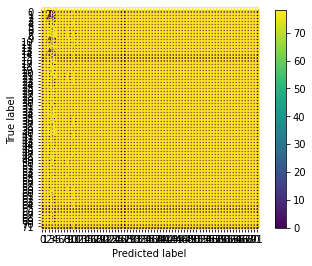

In [ ]:
print("Confusion matrix")
plot_confusion_matrix(SVM_clf, X_test, Y_test)

### Decision Tree

In [ ]:
print("Performance on train set:{}\nPerformance on test set:{}".format(DTC_clf.score(X_train,Y_train),DTC_clf.score(X_test, Y_test)))

Performance on train set:0.9926605504587156
Performance on test set:0.6074866310160428


In [ ]:
DTC_result = {}
char_count = {}
for x,y in zip(X_test,Y_test):
    if not y in DTC_result:
        DTC_result[y] = 0
        char_count[y] = 0
    prediction = DTC_clf.predict(x.reshape(1,x.shape[0]))
    DTC_result[y] += 1 if prediction[0] == int(y) else 0
    char_count[y] += 1
for key in DTC_result:
    print(chars[key],':{}/{}'.format(DTC_result[key],char_count[key])) 

c :36/51
a :14/28
ờ :5/10
ợ :2/6
à :18/30
g :40/49
ạ :3/7
l :15/25
đ :23/30
n :73/87
ứ :3/5
u :13/25
h :59/70
ị :3/4
i :28/48
v :14/17
ả :7/15
b :21/27
o :19/23
q :3/8
ệ :3/5
ô :4/16
ì :2/7
ó :10/21
ê :7/9
t :38/54
ể :2/5
ỉ :0/2
d :5/10
k :11/17
ộ :1/8
ă :0/5
e :0/2
ơ :19/21
ố :0/5
p :4/12
r :4/8
ú :0/2
ã :1/6
ư :8/16
ậ :4/9
ớ :1/4
s :1/7
á :3/10
í :0/6
y :10/16
â :4/9
m :12/19
ẻ :0/2
ừ :3/5
ặ :0/2
x :1/2
ỏ :2/4
ù :5/8
ự :3/8
ở :1/2
ế :1/2
ủ :2/4
ý :2/3
ĩ :0/2
ẫ :0/1
ẽ :0/1
ọ :0/4
ấ :0/1
ử :0/1
é :0/2
ẹ :0/2
ỳ :0/1
ụ :0/1
ề :1/1


Confusion matrix


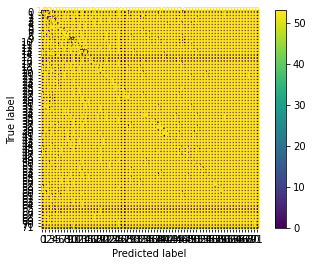

In [ ]:
print("Confusion matrix")
plot_confusion_matrix(DTC_clf, X_test, Y_test)

In [ ]:
classification_report(Y_test, DTC_clf.predict(X_test), target_names=chars)

**Observation:**  
* SVM: The accuracy score is low. Consider its confusion matrix, the non-zero values gather mainly in the main diagonal, but many of them appear in many other place. The model is being underfit
* DTC: In the confusion matrix, we see that its non-zero value mainly appear in the main diagonal. The model work perfectly in the train set, but it is less efficient with the test set. To avoid overfitting, we will build a larger dataset for it later.

## 5. Parameter tuning
We tune the degree of polynomial for the support vector machine algorithm

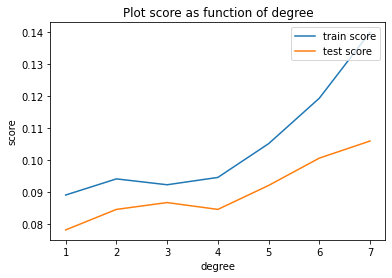

In [ ]:
SVM_clf_set = []
degree_set = []
train_score_set = []
test_score_set = []
for degree in range(1,8):
  degree_set.append(degree)
  tmp_SVM_clf = svm.SVC(kernel='poly',degree=degree,decision_function_shape='ovo').fit(X_train, Y_train)
  SVM_clf_set.append(tmp_SVM_clf)
  train_score_set.append(tmp_SVM_clf.score(X_train, Y_train))
  test_score_set.append(tmp_SVM_clf.score(X_test, Y_test))
plt.title('Plot score as function of degree')
plt.plot(degree_set,train_score_set,degree_set,test_score_set)
#plt.plot(degree_set,test_score_set)
plt.legend(('train score','test score'),loc='upper right')
plt.xlabel('degree')
plt.ylabel('score')
plt.show()

We tune the depth for the decision tree algorithm

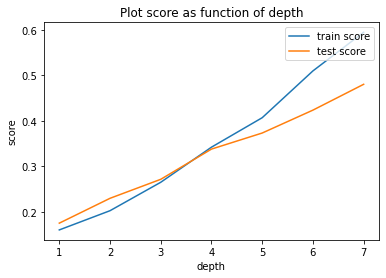

In [ ]:
DTC_clf_set = []
depth_set = []
train_score_set = []
test_score_set = []
for depth in range(1,8):
  depth_set.append(depth)
  tmp_DTC_clf = BaggingClassifier(DecisionTreeClassifier(max_depth=depth,splitter='random',random_state=0), 
                                  random_state=0).fit(X_train, Y_train)
  DTC_clf_set.append(tmp_DTC_clf)
  train_score_set.append(tmp_DTC_clf.score(X_train, Y_train))
  test_score_set.append(tmp_DTC_clf.score(X_test, Y_test))
plt.title('Plot score as function of depth')
plt.plot(degree_set,train_score_set,depth_set,test_score_set)
#plt.plot(degree_set,test_score_set)
plt.legend(('train score','test score'),loc='upper right')
plt.xlabel('depth')
plt.ylabel('score')
plt.show()

**Observation:**  
* SVM: The train score increases when the degree increases. The test set also increase and then stop at about 53%
* DTC: Both the score on train set and test set increase. But there is always a gap between them. The model cannot learn more on this training set

*Note: In the last of this notebook, we tried a larger trainning set to see its affect to the model quality*


## 6. Make prediction:

In [ ]:
def Predict(path):
  instance = extract_features(path)
  instance = np.array(instance)
  instance = instance.reshape(1,instance.shape[0])
  prediction = DTC_clf.predict(instance)
  plt.imshow(cv2.imread(path))
  print("Xin mạnh dạn dự đoán đây là chữ " + chars[prediction[0]])

*Example of false predict*

Xin mạnh dạn dự đoán đây là chữ ư


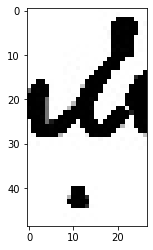

In [ ]:
Predict('/content/MZYYPJU.jpg')

*Example of true predict*

Xin mạnh dạn dự đoán đây là chữ n


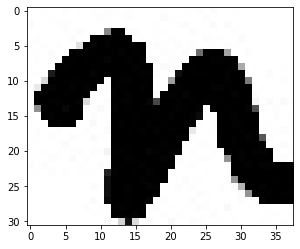

In [ ]:
Predict('/content/BBXVFUE.jpg')